## Federated Learning - Régression logistique

### Ce fichier a pour but d'aider la visualisation du fonctionnement et des performances du Federated Learning via le Federated Averaging dans un contexte de régression logistique avec 2 classes. Le but de notre modèle est donc de données une bonne prédiction quant à la probabilité d'appartenir à la classe 1.

In [1]:
# Importation des modules de génération de données
from FLSimulator import OneDimensionalRDG, OneDimensionalLRDG

# Importation des modèles de machine learning disponibles
from FLSimulator import GDRegressor, LogisticRegressor

# Importation des modules pour créer un réseau fédéré
from FLSimulator import CentralServer, Node, FederatedNetwork

# Importation d'un module a utilisé comme fonction de base phi
from FLSimulator import polynomial_features

from random import randint

### Créons un réseau fédéré simple constitué de 10 bases de données fédérés disposant de 50 à 100 observations tirés d'une distribution uniforme

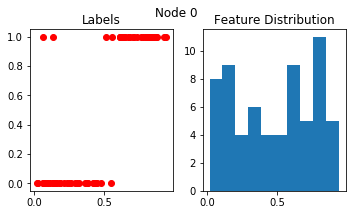

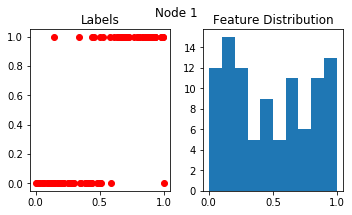

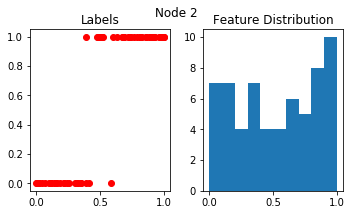

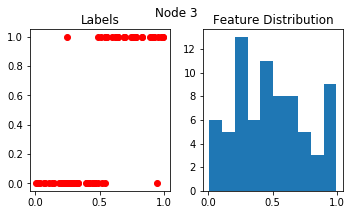

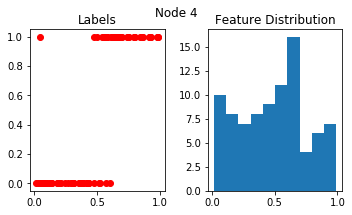

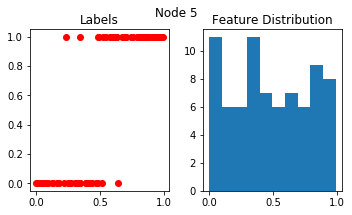

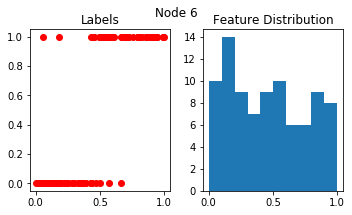

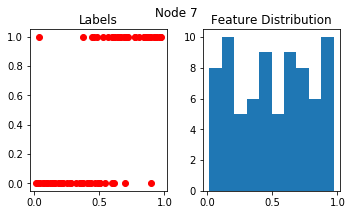

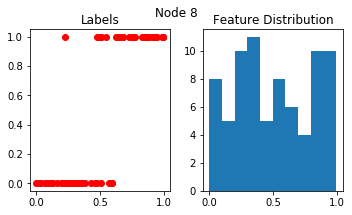

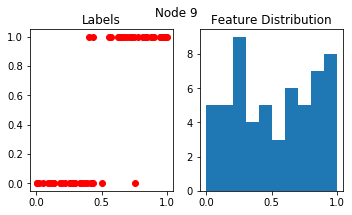

In [2]:
# Création du DataGenerator utilisé pour générer les bases de données de chaque client (Node).
# Les données présenteront un problème de régression logistique simple avec 2 classes

DG = OneDimensionalLRDG(a=1, b=1, noise=0.10, increasing_prob=True, steepness=2)

# Création des Node
nodes = []
for i in range(10):
    X, t = DG.generate_data(randint(50, 100))
    DG.distribution_and_labels(X,t, title='Node ' + str(i))
    nodes.append(Node(X, t))

In [3]:
# Création du modèle global qui sera entraîné et partagé par le réseau
# Modèle de régression logistique avec fonction de base polynomial de degrés 4
phi = polynomial_features(4)
logistic_reg = LogisticRegressor(phi, eta0=1, learning_rate='invscaling')

# Création du server central
#      - Il utilisera le FedAvg pour faire l'aggrégation
#      - Utilisera un sous ensemble aléatoire des nodes ('random') durant chaque round de l'entraînement
#      - Le sous ensemble sera constituté de 80% de l'ensemble des nodes (random_size=0.80)
#      - Utilisera un minibatch size de 1 (C=1) pour les entraînements de chaque Node
#      - Effectuera 200 epochs pour les entraînements de chaque Node

c_server = CentralServer(global_model=logistic_reg, aggregation='FedAvg', node_selection='random', C=1, E=200, random_size=0.80)


In [4]:
# Création du réseau fédéré
f_network = FederatedNetwork(c_server, nodes)

### On effectue maintenant 3 "rounds" d'entraînements et visualisons les performances du modèle global à jour entre chaque "round" en regroupant l'ensemble des bases de données dans une figure commune. Notons ici que la loss utilisée correspond à la _cross entropy_

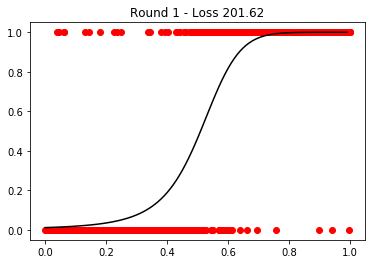

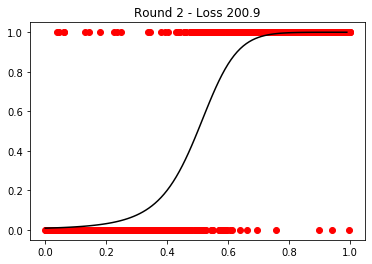

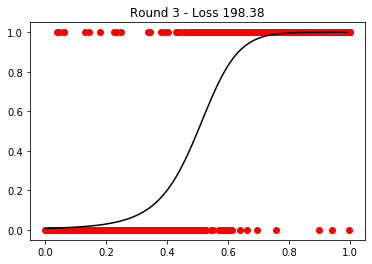

In [5]:
f_network.run_learning(nb_of_rounds=3, show_round_results=(True, 0, 1))

### Reprenons l'exercice qui a été fait dans le précédent notebook _FedAvg_ portant sur la régression polynomial et analysons la situation où les distributions des bases de données fédérées sont non iid. Générons donc 10 nouvelles bases de données fédérées où les distributions de 3 d'entre elles seront davantage tronquées vers la gauche, 3 d'entre elles vers la droite et finalement les 4 distributions restantes seront générées à partir de loi uniforme comme précédement.

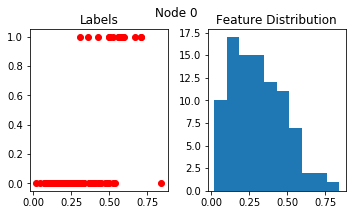

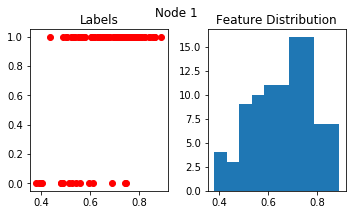

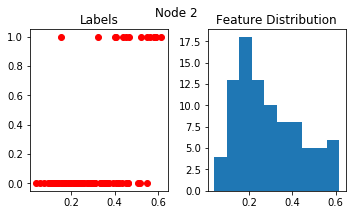

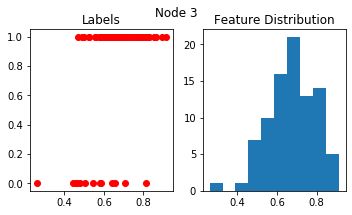

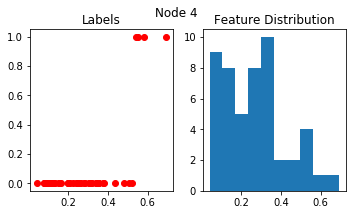

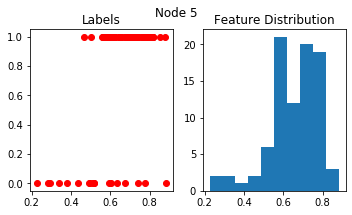

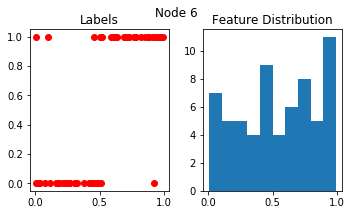

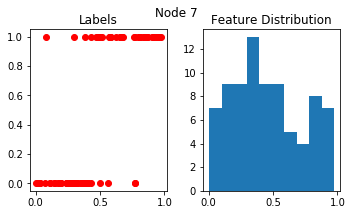

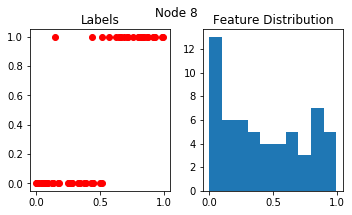

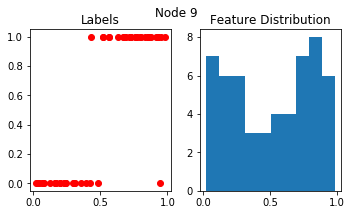

In [7]:
# Création des DataGenerator utilisés pour générer les bases de données de chaque client (Node).

DG_L = OneDimensionalLRDG(a=2, b=5, noise=0.10, increasing_prob=True, steepness=2) # Left Skewed
DG_R = OneDimensionalLRDG(a=8, b=4, noise=0.10, increasing_prob=True, steepness=2) # Right Skewed

# Création des Node
nodes = []
for i in range(3):
    
    X, t = DG_L.generate_data(randint(50, 100))
    DG_L.distribution_and_labels(X,t, title='Node ' + str(2*i))
    nodes.append(Node(X, t))
    
    X, t = DG_R.generate_data(randint(50, 100))
    DG_R.distribution_and_labels(X,t, title='Node ' + str(2*i + 1))
    nodes.append(Node(X, t))
    
for i in range(4):
    
    X, t = DG.generate_data(randint(50, 100))
    DG.distribution_and_labels(X,t, title='Node ' + str(6 + i))
    nodes.append(Node(X, t))

In [9]:
# On "reset" les poids du modèle global
logistic_reg.reset_weights()

# On réinitialise le réseau
f_network = FederatedNetwork(c_server, nodes)

### On entraîne à nouveau le modèle global du réseau, mais cette fois-ci on ira jusqu'à 5 rounds pour voir davantage les performances du Federated Learning

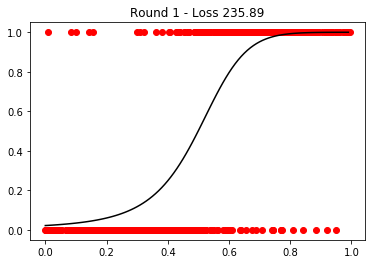

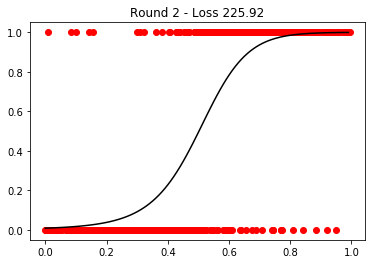

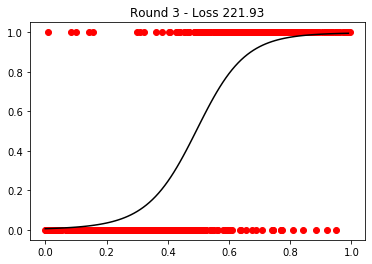

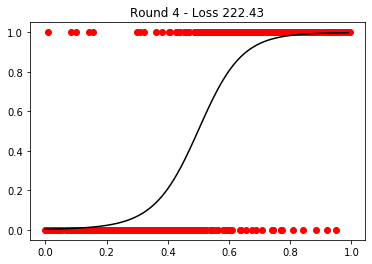

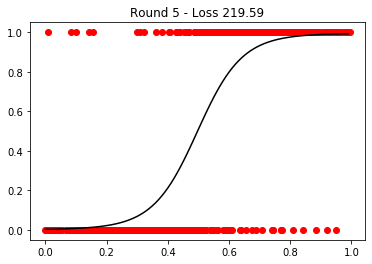

In [10]:
# 5 rounds d'entraînement
f_network.run_learning(nb_of_rounds=5, show_round_results=(True, 0, 1))

### Les résultats semble une fois de plus démontrer une bonne performance liée au federated averaging. On remarque cependant que le comportement de la fonction de perte n'a pas été monotone tout au long de l'entraînement, comme quoi les bases de données sélectionnées aléatoirement lors du round 4 ont eu un impact négatif sur la performance global du modèle

### Finalement, remplaçons une des bases de données provenant d'une distribution uniforme pour des données test générées à partir d'une fonction différente afin d'en évaluer l'impact. De façon similaire à l'exercice réaliser lors de la régression polynomial, on pourrait voir cette nouvelle base de données fédérées comme étant un échantillon d'une population où le comportement de la variable x à un impact complètement différent sur la probabilité d'être dans la classe 1, ou également voir cette situation comme un contexte de _Data Poisonning_  

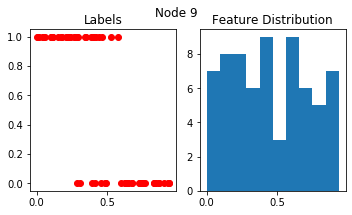

In [12]:
# On "reset" les poids du modèle global
logistic_reg.reset_weights()

# On delete le dernier Node
nodes.pop()

# On initialise un nouveau DataGenerator
DG = OneDimensionalLRDG(a=1, b=1, noise=0.10, increasing_prob=False, steepness=2) # Uniform

# On génère des points et crée un nouveau Node
X, t = DG.generate_data(randint(50, 100))
DG.distribution_and_labels(X,t, title='Node ' + str(6 + i))
nodes.append(Node(X, t))

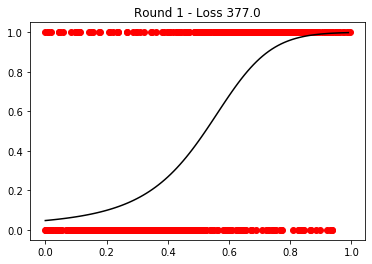

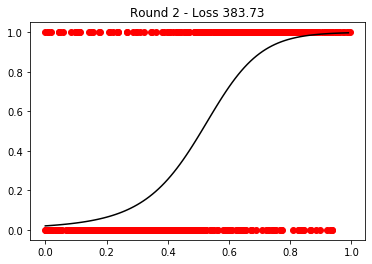

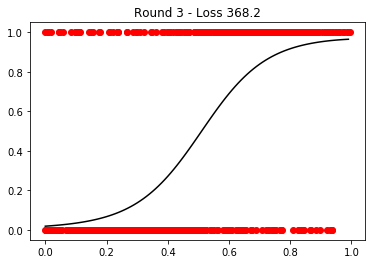

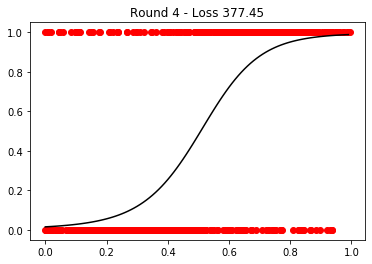

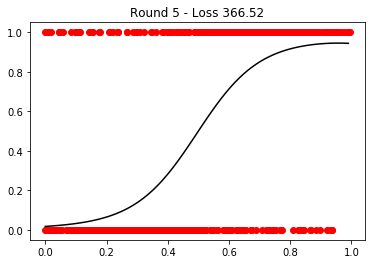

In [13]:
# On réinitialise le réseau avec le même serveur
f_network = FederatedNetwork(c_server, nodes)

# On entraîne à nouveau notre réseau pendant 5 rounds
f_network.run_learning(nb_of_rounds=5, show_round_results=(True, 0, 1))

### L'impact de cette nouvelle base de données fédérées semblent avoir eu un impact plus négatif que dans le cas de la régression polynomial. On peut cependant suggérer que les performances du modèles ne serait pas autant affecté dans un réseau fédérée avec plus vaste où il y aurait davantage de points et également où il serait plus probable que la base entraînant des difficultés ne soit pas sélectionner à plusieurs reprises lors de l'entraînement.

### L'enjeu d'un modèle plus adapté pour la base #9 est soulevé une fois de plus